# Contextual Bandit

In [1]:
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
import copy
from dataclasses import dataclass, field
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive

rng_key = random.PRNGKey(12345)

In [2]:
@dataclass
class State:
    mood: [int] = field(default_factory=list)
    weather: [int] = field(default_factory=list)
    arms: [int] = field(default_factory=list)
    rewards: [int] = field(default_factory=list)


def update(state: State, arm: int, mood: int, weather: int, reward: int) -> State:
    """Update the state with the new arm, mood, weather, and reward"""
    s = copy.deepcopy(state)
    s.mood.append(mood)
    s.weather.append(weather)
    s.arms.append(arm)
    s.rewards.append(reward)
    return s

In [3]:
invlogit = lambda x: 1 / (1 + jnp.exp(-x))


def model(mood, weather, arm, obs=None):
    alpha_0 = numpyro.sample("alpha_0", dist.Normal(0, 1.5))
    alpha_mood = numpyro.sample("alpha_mood", dist.Normal(0, 2).expand((2, 4)))
    alpha_weather = numpyro.sample("alpha_weather", dist.Normal(0, 2).expand((2, 4)))

    logit_p = alpha_0 + alpha_mood[mood, arm] + alpha_weather[weather, arm]
    theta = numpyro.deterministic("theta", invlogit(logit_p))
    numpyro.sample("obs", dist.Binomial(probs=theta), obs=obs)


def estimate_parameters(state: State) -> Predictive:
    """Estimate the parameters of the model using MCMC"""
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, thinning=1, progress_bar=False)    
    mcmc.run(rng_key, obs=jnp.array(state.rewards), arm=state.arms, mood=state.mood, weather=state.weather)
    predictive = Predictive(model, mcmc.get_samples())
    return predictive


class ContextualThompsonSampling:
    @classmethod
    def get_arm(cls, predictive: Predictive, mood: int, weather: int) -> int:
        pred = predictive(rng_key, arm=[0, 1, 2, 3], mood=jnp.array([mood]), weather=jnp.array([weather]))
        n, d = pred['theta'].shape
        theta = pred['theta'][np.random.randint(0, n)]  # Sample a random theta
        arm = np.argmax(theta)
        return arm

    @classmethod
    def print_theta(self, predictive: Predictive):
        mw = [(0, 0), (0, 1), (1, 0), (1, 1)]
        thetas = []
        for m, w in mw:
            pred = predictive(rng_key, arm=[0, 1, 2, 3], mood=jnp.array([m]), weather=jnp.array([w]))
            thetas.append(jnp.mean(pred['theta'], axis=0))
        thetas = jnp.array(thetas)
        print(thetas)

In [4]:
class Environment:
    def __init__(self, thetas: np.array, moods: np.array, weathers: np.array):
        self.thetas = thetas
        self.moods = moods  # 0: active, 1: chill
        self.weathers = weathers  # 0: rainy, 1: sunny

    def get_context(self):
        """Randomly sample a mood and weather"""
        mood = np.random.choice(self.moods)
        weather = np.random.choice(self.weathers)
        return mood, weather


def react(env: Environment, arm: int, mood: int, weather: int) -> int:
    """Return a reward based on the arm, mood, and weather"""
    idx = mood * 2 + weather
    theta = env.thetas[idx]

    if np.random.random() < theta[arm]:
        return 1
    else:
        return 0

In [5]:
moods = jnp.array([0, 1])
weathers = jnp.array([0, 1])
thetas = jnp.array([[1e-3, 1e-3, 0.60, 0.40],  # active, rainy
                    [0.60, 0.20, 1e-3, 0.20],  # active, sunny
                    [1e-3, 1e-3, 0.20, 0.80],  # chill, rainy
                    [0.20, 0.60, 1e-3, 0.20]])  # chill, sunny

env = Environment(thetas, moods, weathers)
state = State()
predictive = estimate_parameters(state)
num_trials = 300

for i in range(num_trials):
    if i % 10 == 0:
        print(f"Iteration {i}")
        predictive = estimate_parameters(state)

    mood, weather = env.get_context()
    arm = ContextualThompsonSampling.get_arm(predictive, mood, weather)
    reward = react(env, arm, mood, weather)
    state = update(state, arm, mood, weather, reward)


Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Iteration 200
Iteration 210
Iteration 220
Iteration 230
Iteration 240
Iteration 250
Iteration 260
Iteration 270
Iteration 280
Iteration 290


In [6]:
ContextualThompsonSampling.print_theta(predictive)

[[0.12704206 0.05125881 0.5983162  0.32734454]
 [0.625497   0.31597605 0.07756158 0.04167894]
 [0.04483411 0.15943621 0.3213771  0.8080674 ]
 [0.30449453 0.6634383  0.03212682 0.22258183]]


In [7]:
for i in range(10):
    m, w = env.get_context()
    pred = predictive(rng_key=rng_key, arm=[0, 1, 2, 3], mood=jnp.array([m]), weather=jnp.array([w]))
    n, d = pred['theta'].shape
    theta = pred['theta'][np.random.randint(0, n)]  # Sample a random theta
    arm = np.argmax(theta)
    print(f"mood: {m}, weather: {w}, arm: {arm}, theta: {theta[arm]}")


mood: 1, weather: 0, arm: 3, theta: 0.8873386979103088
mood: 0, weather: 1, arm: 0, theta: 0.6976399421691895
mood: 0, weather: 1, arm: 0, theta: 0.6415935158729553
mood: 1, weather: 1, arm: 1, theta: 0.6167265176773071
mood: 1, weather: 0, arm: 3, theta: 0.8437976837158203
mood: 0, weather: 1, arm: 0, theta: 0.6700733304023743
mood: 0, weather: 0, arm: 2, theta: 0.6254001259803772
mood: 0, weather: 1, arm: 0, theta: 0.6715057492256165
mood: 0, weather: 0, arm: 2, theta: 0.6767354011535645
mood: 0, weather: 1, arm: 0, theta: 0.7179833054542542


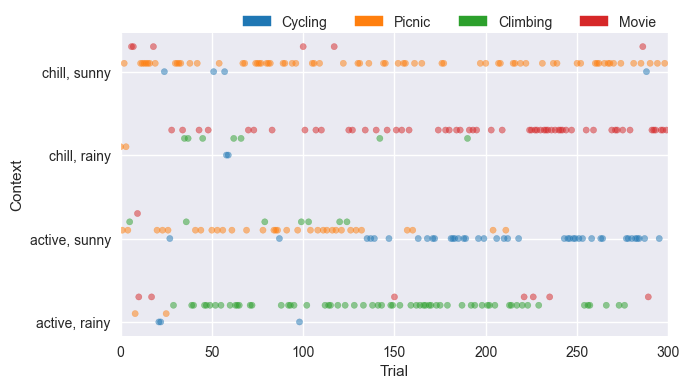

In [44]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")


# Plot a scatter plot of which arm was chosen at each time step
arm_index = [0, 1, 2, 3]
arm_descriptions = ["Cycling", "Picnic", "Climbing", "Movie"]
contexts = [(0, 0), (0, 1), (1, 0), (1, 1)]
context_descriptions = ["active, rainy", "active, sunny", "chill, rainy", "chill, sunny"]
arm_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

# Plot the arm choices
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

c2i = lambda m, w: m * 2 + w


for m, w in contexts:
    for ai, arm in enumerate(arm_index):
        x, y, c = [], [], []
        for i in range(len(state.arms)):            
            if state.mood[i] == m and state.weather[i] == w and state.arms[i] == arm:
                x.append(i)
                y.append(c2i(m, w) + ai * 0.1)
                c.append(arm_colors[arm])
        ax.scatter(x, y, c=c, s=20, alpha=0.5)
    
ax.set_yticks(range(len(contexts)), context_descriptions)
ax.set_ylabel("Context")
ax.set_xlabel("Trial")
ax.set_xlim([0, 300])

handles = []
for arm in arm_index:
    h = mpatches.Patch(color=arm_colors[arm], label=arm_descriptions[arm])
    handles.append(h)
plt.legend(handles=handles, bbox_to_anchor=(1., 1.1), loc="upper right", ncols=4)
plt.tight_layout()
plt.show()

In [45]:
thetas

Array([[0.004, 0.004, 0.6  , 0.4  ],
       [0.6  , 0.2  , 0.004, 0.2  ],
       [0.004, 0.004, 0.2  , 0.8  ],
       [0.2  , 0.6  , 0.004, 0.2  ]], dtype=float32)